In [9]:
from scipy import *
import numpy as np
%matplotlib inline

In [2]:
ID, Mvir, Vmax, Rvir, Rs, x, y, z, Spin, PID = load('cat/mnv_0.6_66_parents.npy').T

In [40]:
logM = log10(Mvir)
logMbins12 = percentile(logM[ (logM>=12.0) & (logM<14.0)], linspace(0,100,101))
logMbins14 = percentile(logM[(logM>=14.0) & (logM<15.5)], linspace(0,100,51))
#logMbins = concatenate( [logMbins12, logMbins14])
print unique(logMbins12).shape, unique(logMbins14).shape

(101,) (51,)


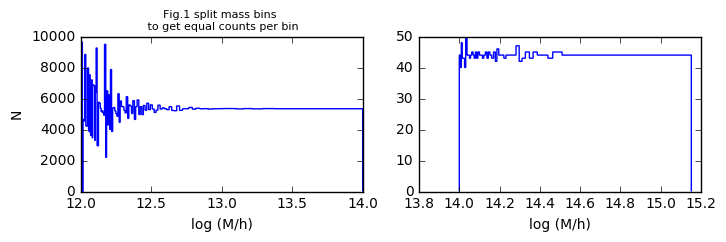

In [43]:
f, (ax1,ax2) = subplots(1,2, figsize=(8,2))
ax1.hist(logM, bins=logMbins12, histtype='step')
ax2.hist(logM, bins=logMbins14, histtype='step')
ax1.set_xlabel('log (M/h)')
ax2.set_xlabel('log (M/h)')
ax1.set_ylabel('N')
ax1.set_title('Fig.1 split mass bins \n to get equal counts per bin', fontsize=8)
show()